In [2]:
import os
import glob
import pickle
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gatspy import periodic
from astropy.timeseries import LombScargle

from psearch_py import *

import warnings
warnings.filterwarnings('ignore')

# Preparing Dataset From Saha et al. (2017)

In [3]:
saha = pd.read_csv('392work2.tab', sep = '\s{5}', header = None, 
                   names = ['HJD-2400000.0', 'Magnitude', 'Uncertainty in Magnitude', 'Passband'], engine = 'python')
saha.info()
saha.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 4 columns):
HJD-2400000.0               370 non-null float64
Magnitude                   370 non-null float64
Uncertainty in Magnitude    370 non-null float64
Passband                    370 non-null float64
dtypes: float64(4)
memory usage: 11.6 KB


,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,0.0
1,56423.812500,28.160,0.029,0.0
2,56423.894531,28.089,0.021,0.0
3,56424.718750,27.882,0.024,0.0
4,56424.808594,28.105,0.029,0.0


In [4]:
saha['Passband'] = saha['Passband'].replace({0.0 : 'u', 1.0 : 'g', 2.0 : 'r', 3.0 : 'i', 4.0: 'z'})
saha.to_csv('saha.csv', index = False)
saha.head()

,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,56423.664062,27.769,0.030,u
1,56423.812500,28.160,0.029,u
2,56423.894531,28.089,0.021,u
3,56424.718750,27.882,0.024,u
4,56424.808594,28.105,0.029,u


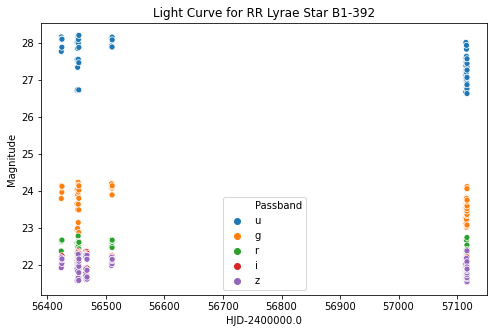

In [5]:
plt.figure(figsize = (8, 5))
plt.title('Light Curve for RR Lyrae Star B1-392')
sns.scatterplot(x = 'HJD-2400000.0', y = 'Magnitude', data = saha, hue = 'Passband');

In [6]:
# Code from Saha et al. (2017)

hjd, mag, mag_err = saha["HJD-2400000.0"].values, saha["Magnitude"].values, saha["Uncertainty in Magnitude"].values
num_filts = pd.read_csv('392work2.tab', sep = '\s{5}', header = None, engine = 'python',
                        names = ['HJD-2400000.0', 'Magnitude', 'Uncertainty in Magnitude', 'Passband'])["Passband"].values
saha_periods, saha_lomb, saha_lk, saha_psi, saha_conf = periodpsi2_py(hjd, mag, mag_err, num_filts, 0.2, 0.02, 1)

periodpsi2: BEGIN
periodpsi2: minimum and maximum periods:     0.20000176   346.62304690 days
periodpsi2: number of period (frequency) samples:  173211   <----------
periodpsi2:  68  observations  <----------
scargle: DONE     3.981 seconds
ctheta_slave: DONE     2.577 seconds
periodpsi2_py:  1  of  1   (thresh loop)
scargle: DONE     4.178 seconds
ctheta_slave: DONE     0.648 seconds
scargle: DONE     4.541 seconds
ctheta_slave: DONE     0.643 seconds
periodpsi2: END


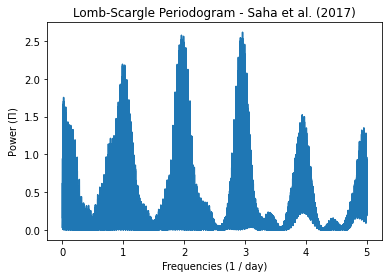

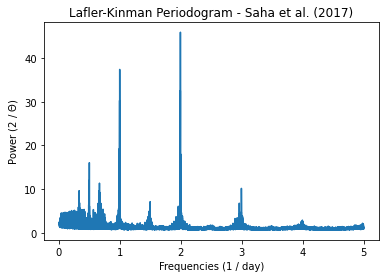

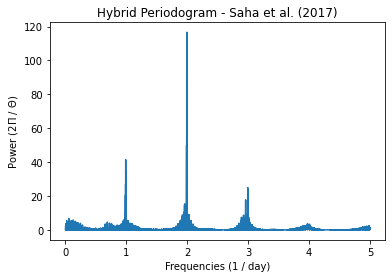

In [7]:
# Plots in Saha et al. (2017)

saha_freqs = 1 / saha_periods

plt.figure()
plt.xlabel('Frequencies (1 / day)')
plt.ylabel(r'Power ($\Pi$)')
plt.title(f'Lomb-Scargle Periodogram - Saha et al. (2017)')
plt.plot(saha_freqs, saha_lomb);
    
plt.figure()
plt.xlabel('Frequencies (1 / day)')
plt.ylabel(r'Power ($2$ / $\Theta$)')
plt.title(f'Lafler-Kinman Periodogram - Saha et al. (2017)')
plt.plot(saha_freqs, 2 / saha_lk);

plt.figure()
plt.xlabel('Frequencies (1 / day)')
plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
plt.title(f'Hybrid Periodogram - Saha et al. (2017)')
plt.plot(saha_freqs, saha_psi);

# Computing the Hybrid Statistic

In [8]:
def phase_dispersion_minimization(times, magnitudes, uncertainties, periods, weighted = True):
    """Implements the formula for calculating the Lafler-Kinman statistic
    using weighted phase dispersion minimization."""
    
    lafler_kinmans = []
    for period in periods:
        
        folded = (times / period) % 1
        ordered = sorted(list(zip(folded, magnitudes, uncertainties)), key = lambda x: x[0])
        unzipped = [list(t) for t in zip(*ordered)]
        measurements, errors = unzipped[1], unzipped[2]
        wrap_measurements = [measurements[-1]] + measurements
        wrap_errors = [errors[-1]] + errors
        
        weights = []
        for i in range(1, len(wrap_errors)):
            weights.append(1 / (wrap_errors[i]**2 + wrap_errors[i - 1]**2))
        
        numerator = []
        for j in range(1, len(wrap_measurements)):
            difference = (wrap_measurements[j] - wrap_measurements[j - 1])**2
            if weighted:
                numerator.append(difference * weights[j - 1])
            else:
                numerator.append(difference)
        
        if weighted:
            weighted_mean = np.mean(np.array(measurements) * np.array(weights))
            denominator = sum(weights)*sum((np.array(measurements) - weighted_mean)**2)
        else:
            denominator = sum((np.array(measurements) - np.mean(measurements))**2)
            
        lafler_kinman = sum(numerator) / denominator
        lafler_kinmans.append(lafler_kinman)

    return np.array(lafler_kinmans)


def lomb_scargle_analysis(times, magnitudes, uncertainties, min_period = 0.2, max_period = 1.5, version = "gatspy"):
    """Generates the Lomb-Scargle periodogram for a variable star light curve."""
    
    fit_periods = np.linspace(min_period, max_period, 10000)
    
    if version == "gatspy":
        model = periodic.LombScargleFast(fit_period = True)
        model.optimizer.period_range = (min_period, max_period)
        model.fit(times, magnitudes, uncertainties)
        results = model.score(fit_periods)
    else:
        astropy_model = LombScargle(times, magnitudes, uncertainties, normalization = 'psd', fit_mean = False)
        results = astropy_model.power(1 / fit_periods, method = 'slow')
        # results = LombScargle(times, magnitudes, normalization='psd', fit_mean=False).power(1 / fit_periods, method='slow')
        
    return [fit_periods, results]


def hybrid_statistic(times, magnitudes, uncertainties, version = "gatspy", weighted = True):
    """Computes the hybrid statistic defined by Saha et al. (2017).
    Then, uses the hybrid statistic to find the best period."""
    
    periods, pi = lomb_scargle_analysis(times, magnitudes, uncertainties, version = version)
    theta = phase_dispersion_minimization(times, magnitudes, uncertainties, periods, weighted = weighted)
    hybrid_statistic = np.array(2 * pi / theta)
    best_period = periods[np.argmax(hybrid_statistic)]
    return [1 / periods, pi, 2 / theta, hybrid_statistic, best_period]

In [9]:
def filter_data(dataset, passband, **kwargs):
    """Returns light curve data for a specific star in a specific passband."""
    
    filtered = dataset[dataset["Passband"] == passband]
    
    for elem in kwargs.keys():
        try:
            filtered = filtered[filtered[elem.capitalize()] == kwargs.get(elem)]
        except KeyError as e:
            print(f"Dataset does not contain {e.args[0]} column. Attempting to filter based on additional keyword arguments.")
    
    epoch = filtered["HJD-2400000.0"].values
    magnitudes = filtered["Magnitude"].values
    magnitude_errors = filtered["Uncertainty in Magnitude"].values
    return epoch, magnitudes, magnitude_errors


def plot_periodogram(dataset, passband, version = "gatspy", weighted = True, plot = True, name = "Unknown", **kwargs):
    """Plots Lomb-Scargle, Lafler-Kinman, and hybrid periodograms for a variable star light curve."""
    
    epoch, magnitudes, magnitude_errors = filter_data(dataset, passband, **kwargs)
    frequencies, ls_powers, lk_powers, hybrid_powers, best_period = hybrid_statistic(epoch, magnitudes, magnitude_errors, 
                                                                                     version = version, weighted = weighted)
    
    if plot:
        
        if 'star' in kwargs.keys():
            name = kwargs.get('star')
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title(f'Lomb-Scargle Periodogram for {passband} Passband')
        plt.plot(frequencies, ls_powers, label = name)
        plt.legend()
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title(f'Lafler-Kinman Periodogram for {passband} Passband')
        plt.plot(frequencies, lk_powers, label = name)
        plt.legend()
    
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title(f'Hybrid Periodogram for {passband} Passband')
        plt.plot(frequencies, hybrid_powers, label = name)
        plt.legend();
    
    return [frequencies, ls_powers, lk_powers, hybrid_powers, best_period]

In [10]:
def find_best_period(dataset, version = "gatspy", weighted = True, plot = True, name = "Unknown", **kwargs):
    """Find the best period by averaging across the results from each passband."""
    
    passbands = dataset["Passband"].unique()
    freqs, ls_powers, lk_powers, hybrid_powers, period = plot_periodogram(dataset, passbands[0], version = version, 
                                                                          weighted = weighted, plot = False, **kwargs)
    print('\n')
    
    for passband in passbands[1:]:
        new_results = plot_periodogram(dataset, passband, version = version, weighted = weighted, plot = False, **kwargs)
        ls_powers = ls_powers + new_results[1]
        lk_powers = lk_powers + new_results[2]
        hybrid_powers = hybrid_powers + new_results[3]
        print('\n')
        
    if plot:
        
        if 'star' in kwargs.keys():
            name = kwargs.get('star')
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($\Pi$)')
        plt.title('Lomb-Scargle Periodogram for All Passbands')
        plt.plot(freqs, ls_powers, label = name)
        plt.legend()
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2$ / $\Theta$)')
        plt.title('Lafler-Kinman Periodogram for All Passbands')
        plt.plot(freqs, lk_powers, label = name)
        plt.legend()
        
        plt.figure()
        plt.xlabel('Frequencies (1 / day)')
        plt.ylabel(r'Power ($2\Pi$ / $\Theta$)')
        plt.title('Hybrid Periodogram for All Passbands')
        plt.plot(freqs, hybrid_powers, label = name)
        plt.legend();
        
    best_ls_period = 1 / (freqs[np.argmax(ls_powers)])
    best_lk_period = 1 / (freqs[np.argmax(lk_powers)])
    best_hybrid_period = 1 / (freqs[np.argmax(hybrid_powers)])
    
    return [best_ls_period, best_lk_period, best_hybrid_period]

In [11]:
def phase_light_curve(best_period, dataset, passband, name = "Unknown", **kwargs):
    """Phases the variable star light curve based on the best period.
    Then, plots the phased light curve in the specified passband."""
    
    if 'star' in kwargs.keys():
        name = kwargs.get('star')
    
    times, magnitudes, magnitude_errors = filter_data(dataset, passband, **kwargs)
    phases = (times / best_period) % 1
    
    plt.figure()
    plt.title(f'Phased Light Curve in {passband} Passband')
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.scatter(phases, magnitudes, label = name)
    plt.errorbar(phases, magnitudes, yerr = magnitude_errors, linestyle = 'None')
    plt.legend();
    
    return phases

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in g Passband is 0.5016301630163016
True Period is 0.501624 Days


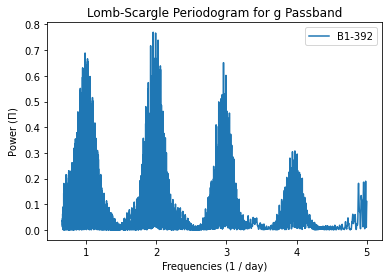

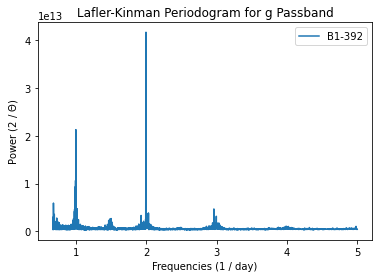

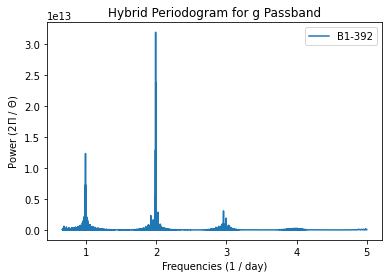

In [12]:
true_period = 0.5016240
g_period = plot_periodogram(saha, 'g', name = 'B1-392')[4];

print("\nBest Period in g Passband is", g_period)
print("True Period is", true_period, "Days")

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 

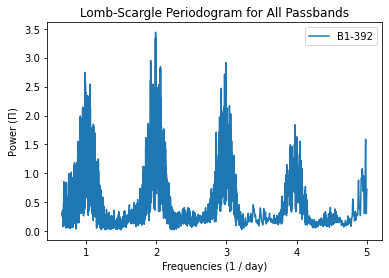

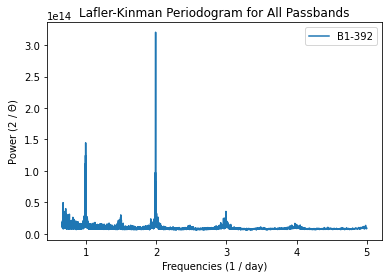

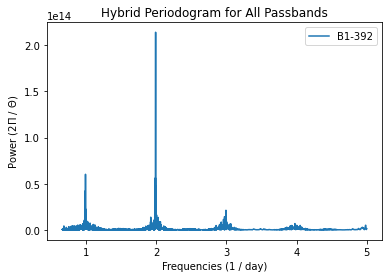

In [13]:
best_period = find_best_period(saha, name = 'B1-392')[2];

print("Best Period is", best_period, "Days")
print("True Period is", true_period, "Days")

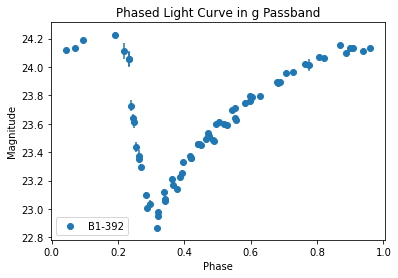

In [14]:
phases = phase_light_curve(best_period, saha, 'g', name = 'B1-392')

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


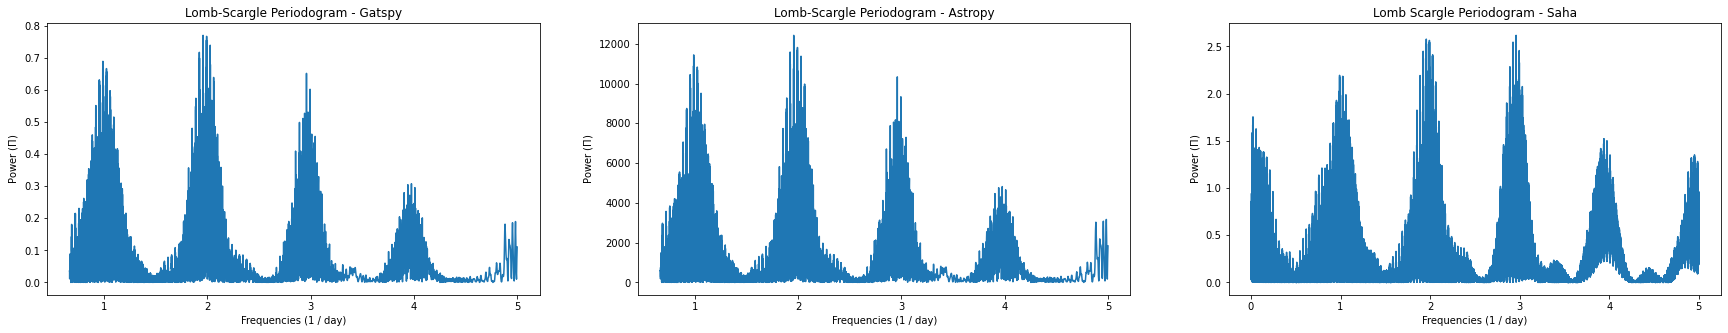

In [15]:
gatspy_freqs, gatspy_ls = hybrid_statistic(*filter_data(saha, "g"))[:2]
astropy_freqs, astropy_ls = hybrid_statistic(*filter_data(saha, "g"), version = "astropy")[:2]

comp_fig, comp_axs = plt.subplots(1, 3, figsize = (30, 5))
for ax in comp_axs:
    ax.set_xlabel('Frequencies (1 / day)')
    ax.set_ylabel(r'Power ($\Pi$)')

comp_axs[0].set_title('Lomb-Scargle Periodogram - Gatspy')
comp_axs[0].plot(gatspy_freqs, gatspy_ls);

comp_axs[1].set_title('Lomb-Scargle Periodogram - Astropy')
comp_axs[1].plot(astropy_freqs, astropy_ls);

comp_axs[2].set_title('Lomb Scargle Periodogram - Saha')
comp_axs[2].plot(saha_freqs, saha_lomb);

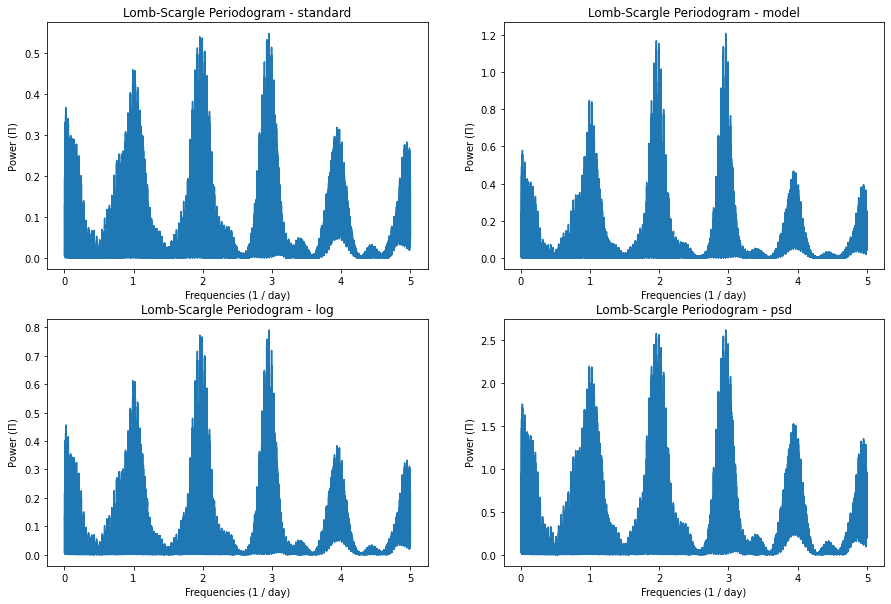

In [16]:
astro_fig, astro_axs = plt.subplots(2, 2, figsize = (15, 10))
astro_axs = astro_axs.reshape(1, 4)[0]
for ax in astro_axs:
    ax.set_xlabel('Frequencies (1 / day)')
    ax.set_ylabel(r'Power ($\Pi$)')
    
normalizations = ["standard", "model", "log", "psd"]

for i in range(4):
    astro_model = LombScargle(*filter_data(saha, 'g')[:2], normalization = normalizations[i], fit_mean = False)
    astro_ls = astro_model.power(saha_freqs, method = 'slow')
    astro_axs[i].set_title(f"Lomb-Scargle Periodogram - {normalizations[i]}")
    astro_axs[i].plot(saha_freqs, astro_ls)

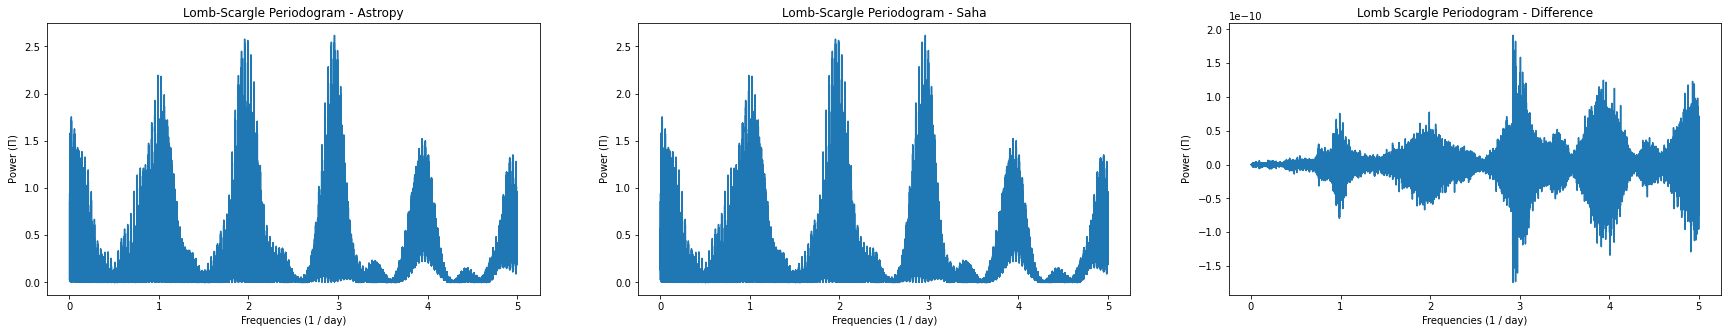

In [17]:
comp_fig, comp_axs = plt.subplots(1, 3, figsize = (30, 5))
for ax in comp_axs:
    ax.set_xlabel('Frequencies (1 / day)')
    ax.set_ylabel(r'Power ($\Pi$)')
    
astro_model = LombScargle(*filter_data(saha, 'g')[:2], normalization = 'psd', fit_mean = False)
astro_ls = astro_model.power(saha_freqs, method = 'slow')

comp_axs[0].set_title('Lomb-Scargle Periodogram - Astropy')
comp_axs[0].plot(saha_freqs, astro_ls);

comp_axs[1].set_title('Lomb-Scargle Periodogram - Saha')
comp_axs[1].plot(saha_freqs, saha_lomb);

comp_axs[2].set_title('Lomb Scargle Periodogram - Difference')
comp_axs[2].plot(saha_freqs, astro_ls - saha_lomb);

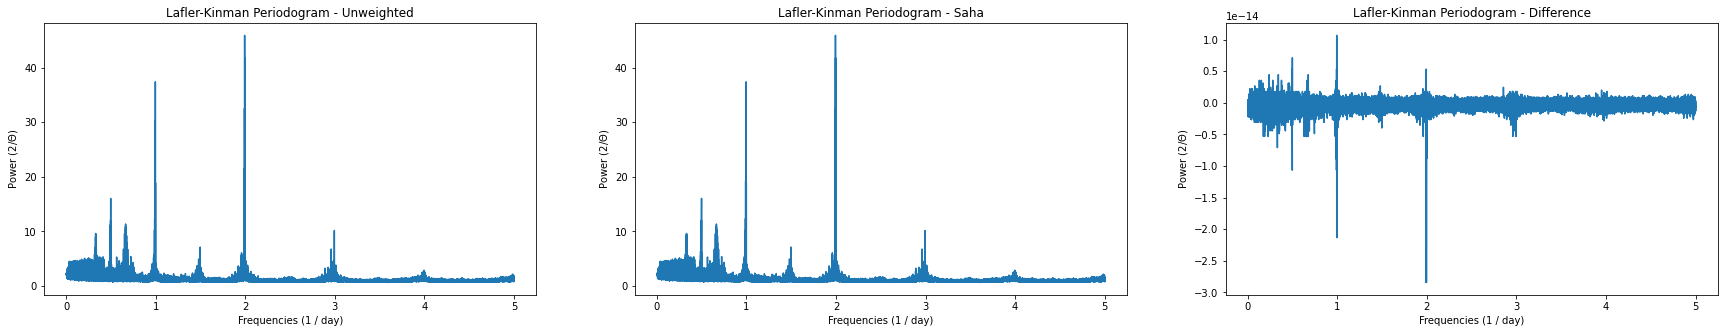

In [18]:
unweighted_lk = phase_dispersion_minimization(*filter_data(saha, 'g'), periods = 1 / saha_freqs, weighted = False)

lk_comp_fig, lk_comp_axs = plt.subplots(1, 3, figsize = (30, 5))
for ax in lk_comp_axs:
    ax.set_xlabel('Frequencies (1 / day)')
    ax.set_ylabel(r'Power ($2/\Theta$)')

lk_comp_axs[0].set_title('Lafler-Kinman Periodogram - Unweighted')
lk_comp_axs[0].plot(saha_freqs, 2 / unweighted_lk);

lk_comp_axs[1].set_title('Lafler-Kinman Periodogram - Saha')
lk_comp_axs[1].plot(saha_freqs, 2 / saha_lk);

lk_comp_axs[2].set_title('Lafler-Kinman Periodogram - Difference')
lk_comp_axs[2].plot(saha_freqs, 2 / unweighted_lk - 2 / saha_lk);

# Application to Hubble Space Telescope Data

In [19]:
path = 'J_ApJ_850_137'
photometry_data = glob.glob(os.path.join(path, 'b2*.dat'))

hubble_names_1 = ['Galaxy', 'Star', 'HJD-2400000.0 (F475W)', 'Magnitude (F475W)', 'Uncertainty in Magnitude (F475W)',
                 'HJD-2400000.0 (F814W)', 'Magnitude (F814W)', 'Uncertainty in Magnitude (F814W)']

hubble_photometry = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names_1, engine = 'python') 
                               for file in photometry_data)).sort_values(by = ['Galaxy', 'Star']).dropna()

hubble_photometry['Star'] = hubble_photometry['Star'].str.replace('-', '')
hubble_F475W = hubble_photometry.iloc[:, :5]
hubble_F814W = pd.concat([hubble_photometry.iloc[:, :2], hubble_photometry.iloc[:, 5:]], axis = 1)

hubble_F475W['Passband'] = 'F475W'
hubble_F475W.rename({'HJD-2400000.0 (F475W)' : 'HJD-2400000.0', 'Magnitude (F475W)' : 'Magnitude', 
                    'Uncertainty in Magnitude (F475W)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

hubble_F814W['Passband'] = 'F814W'
hubble_F814W.rename({'HJD-2400000.0 (F814W)' : 'HJD-2400000.0', 'Magnitude (F814W)' : 'Magnitude', 
                    'Uncertainty in Magnitude (F814W)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

hubble_photometry = pd.concat([hubble_F475W, hubble_F814W], axis = 0).sort_values(by = ['Galaxy', 'Star'])
hubble_photometry.to_csv('hubble.csv', index = False)
hubble_photometry.head()

,Galaxy,Star,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,AndI,V001,57266.425781,25.254,0.089,F475W
1,AndI,V001,57266.500000,25.523,0.056,F475W
2,AndI,V001,57266.691406,25.801,0.041,F475W
3,AndI,V001,57266.765625,25.917,0.064,F475W
4,AndI,V001,57267.417969,25.175,0.036,F475W


In [20]:
pulsation_data = glob.glob(os.path.join(path, 'd4*.dat'))

hubble_names_2 = ['Galaxy', 'Star', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                  'Dec (Seconds)', 'Period (Days)', 'Magnitude (F475W)', 'Amplitude (F475W)', 'Magnitude (F814W)', 
                  'Amplitude (F814W)', 'Magnitude (B-Band)', 'Amplitude (B-Band)', 'Magnitude (V-Band)', 'Amplitude (V-Band)', 
                  'Magnitude (Ic-Band)', 'Amplitude (Ic-Band)', 'Variable Type', 'Camera']

hubble_pulsation = pd.concat((pd.read_csv(file, sep = '\s{1,}', header = None, names = hubble_names_2, engine = 'python') 
                              for file in pulsation_data)).sort_values(by = ['Galaxy', 'Star'])

hubble_pulsation['Star'] = hubble_pulsation['Star'].str.replace('-', '')
hubble_pulsation.head()

,Galaxy,Star,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Magnitude (F475W),...,Magnitude (F814W),Amplitude (F814W),Magnitude (B-Band),Amplitude (B-Band),Magnitude (V-Band),Amplitude (V-Band),Magnitude (Ic-Band),Amplitude (Ic-Band),Variable Type,Camera
0,AndI,V001,0,45,9.233,37,58,47.19,0.569,25.532,...,24.692,0.574,25.657,1.137,25.266,0.915,24.677,0.580,RRab,WFC3
1,AndI,V002,0,45,9.646,37,59,48.86,0.567,25.505,...,24.737,0.358,25.613,0.669,25.251,0.436,24.719,0.360,RRab,WFC3
2,AndI,V003,0,45,9.819,37,59,32.31,0.296,25.329,...,24.831,0.091,25.398,0.392,25.159,0.207,24.819,0.097,RRc,WFC3
3,AndI,V004,0,45,10.116,37,58,44.43,0.598,25.322,...,24.607,0.699,25.415,1.605,25.103,0.949,24.599,0.669,RRab,WFC3
4,AndI,V005,0,45,10.429,37,58,56.47,0.585,25.557,...,24.733,0.608,25.680,0.864,25.276,0.660,24.722,0.576,RRab,WFC3


In [21]:
hubble_periods = hubble_pulsation[['Galaxy', 'Star', 'Period (Days)']]
hubble_periods.info()

hubble_periods.to_csv('hubble_periods.csv', index = False)
hubble_periods.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 89
Data columns (total 3 columns):
Galaxy           895 non-null object
Star             895 non-null object
Period (Days)    895 non-null float64
dtypes: float64(1), object(2)
memory usage: 28.0+ KB


,Galaxy,Star,Period (Days)
0,AndI,V001,0.569
1,AndI,V002,0.567
2,AndI,V003,0.296
3,AndI,V004,0.598
4,AndI,V005,0.585


Finding optimal frequency:
 - Estimated peak width = 1.18
 - Using 5 steps per peak; omega_step = 0.237
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 117 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in F475W Passband is 0.5637763776377638 Days


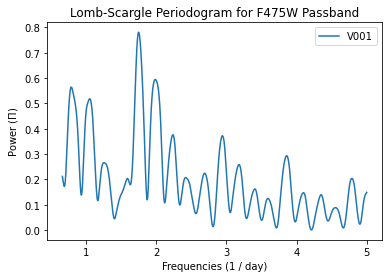

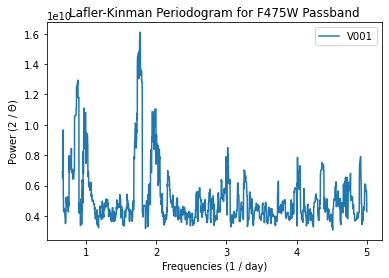

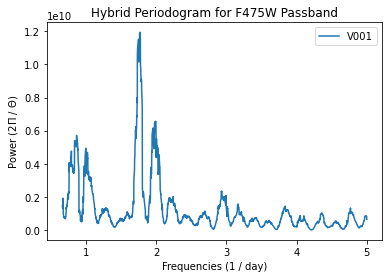

In [22]:
best_period_AndI_V001_F475W = plot_periodogram(hubble_photometry, 'F475W', star = 'V001', galaxy = 'AndI')[4];
print(f"\nBest Period in F475W Passband is {best_period_AndI_V001_F475W} Days")

Finding optimal frequency:
 - Estimated peak width = 1.18
 - Using 5 steps per peak; omega_step = 0.237
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 117 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 1.19
 - Using 5 steps per peak; omega_step = 0.238
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 116 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps



Best Period is 0.5676767676767677 Days


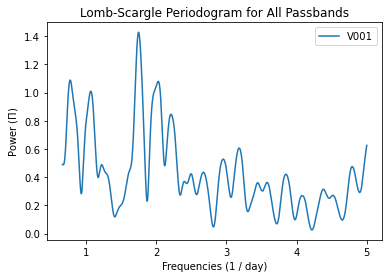

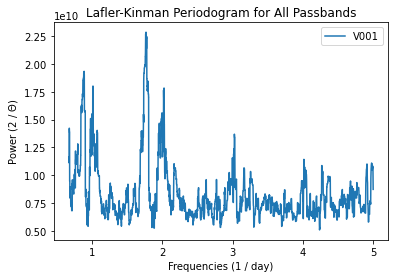

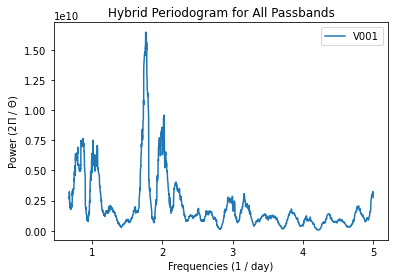

In [23]:
best_period_AndI_V001 = find_best_period(hubble_photometry, star = 'V001', galaxy = 'AndI')[2];
print(f"\nBest Period is {best_period_AndI_V001} Days")

In [24]:
hubble_best_periods = np.array(pickle.load(open("hubble_periods_unweighted.pkl", "rb")))[:, 2:].T[0]
hubble_periods['Best Period (Days)'] = hubble_best_periods
hubble_periods.head()

,Galaxy,Star,Period (Days),Best Period (Days)
0,AndI,V001,0.569,0.566396
1,AndI,V002,0.567,0.569529
2,AndI,V003,0.296,0.293952
3,AndI,V004,0.598,0.599325
4,AndI,V005,0.585,0.585935


In [25]:
np.average(np.abs(hubble_periods.iloc[:, 3] - hubble_periods.iloc[:, 2]))

0.017330902638635324

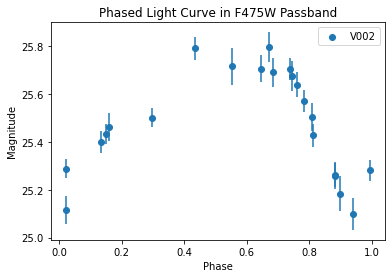

In [26]:
AndI_V001_phases = phase_light_curve(hubble_periods.iloc[1, 3], hubble_photometry, 'F475W', star = 'V002', galaxy = 'AndI')

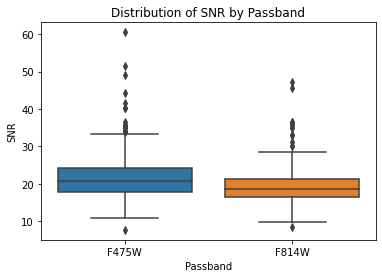

In [69]:
hubble_data = hubble_photometry.copy()
hubble_data['SNR'] = 1 / (10**(hubble_data['Uncertainty in Magnitude'] / 2.5) - 1)

hubble_pass = hubble_data[['Galaxy', 'Star', 'Passband', 'SNR']].groupby(['Galaxy', 'Star', 'Passband']).mean().reset_index()
sns.boxplot(data = hubble_pass, x = 'Passband', y = 'SNR')
plt.title('Distribution of SNR by Passband');

,Galaxy,Star,SNR,Difference
0,AndI,V001,16.668341,0.002604
1,AndI,V002,16.522371,0.002529
2,AndI,V003,17.591154,0.002048
3,AndI,V004,19.156996,0.001325
4,AndI,V005,16.011397,0.000935


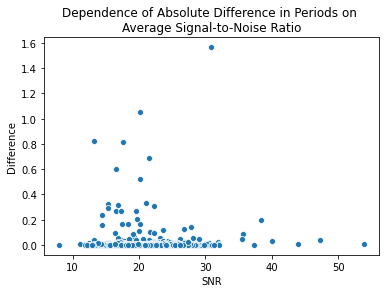

In [92]:
hubble_data = hubble_data[['Galaxy', 'Star', 'SNR']]
hubble_data = hubble_data.groupby(['Galaxy', 'Star']).mean().reset_index()

hubble_diff = np.abs(hubble_periods['Period (Days)'] - hubble_best_periods).values
hubble_data['Difference'] = hubble_diff
display(hubble_data.head())

sns.scatterplot(data = hubble_data, x = 'SNR', y = 'Difference')
plt.title('Dependence of Absolute Difference in Periods on \nAverage Signal-to-Noise Ratio');

In [95]:
sorted_hubble_diff = hubble_data.sort_values(by = 'Difference', ascending = False)
print(len(hubble_data[hubble_data['Difference'] < 0.01]), len(hubble_data))
sorted_hubble_diff.head()

739 895


,Galaxy,Star,SNR,Difference
791,AndXV,V117,30.844981,1.565927
398,AndII,V097,20.102434,1.049517
68,AndI,V069,13.192448,0.819953
160,AndI,V161,17.601299,0.814462
535,AndII,V234,21.440665,0.684968


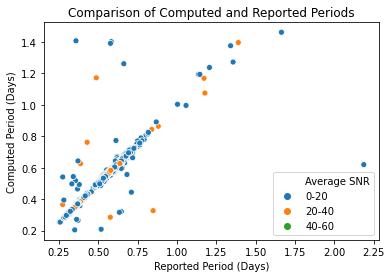

In [96]:
weighted_hubble = hubble_periods.copy()
weighted_hubble = weighted_hubble.rename({'Best Period (Days)' : 'Computed Period (Days)', 
                                          'Period (Days)' : 'Reported Period (Days)'}, axis = 1)
weighted_hubble['SNR'] = hubble_data['SNR']

hubble_bins = [0, 20, 40, 60]
hubble_labels = ['0-20', '20-40', '40-60']
weighted_hubble['Average SNR'] = pd.cut(weighted_hubble['SNR'], bins = hubble_bins, labels = hubble_labels)

sns.scatterplot(data = weighted_hubble, x = 'Reported Period (Days)', y = 'Computed Period (Days)', 
                hue = 'Average SNR', hue_order = hubble_labels)
plt.title('Comparison of Computed and Reported Periods')
plt.xlabel('Reported Period (Days)')
plt.ylabel('Computed Period (Days)');

# Application to Sculptor Data

In [27]:
sculptor_path_1 = os.path.join('J_MNRAS_462_4349', 'table4.dat')

sculptor_names_1 = ['Star', 'Name 1', 'Name 2', 'RA (Hour)', 'RA (Minutes)', 'RA (Seconds)', 'Dec (Degrees)', 'Dec (Minutes)', 
                    'Dec (Seconds)', 'Period (Days)', 'Uncertainty Flag on Period', 'Mean Magnitude (B)', 'Mean Magnitude (V)', 
                    'Mean Magnitude (I)', 'Amplitude (B)', 'Amplitude (V)', 'Amplitude (I)', 'Quality Flag 1', 'Quality Flag 2',
                    'Variable Type']

sculptor_pulsation = pd.read_csv(sculptor_path_1, sep = '\s{1,}', header = None, names = sculptor_names_1, engine = 'python', 
                                 usecols = [i for i in range(21)])

sculptor_pulsation = sculptor_pulsation.replace({"--" : np.nan, "----" : np.nan, "-----" : np.nan})
sculptor_pulsation.head()

,Star,Name 1,Name 2,RA (Hour),RA (Minutes),RA (Seconds),Dec (Degrees),Dec (Minutes),Dec (Seconds),Period (Days),Uncertainty Flag on Period,Mean Magnitude (B),Mean Magnitude (V),Mean Magnitude (I),Amplitude (B),Amplitude (V),Amplitude (I),Quality Flag 1,Quality Flag 2,Variable Type
0,scl-CEMV001,V461,NaN,0,55,21.02,-33,41,1.5,0.420876,::,20.150,19.830,19.460,0.900,0.630,0.000,1,0,RRab
1,scl-CEMV002,NaN,NaN,0,56,9.15,-33,29,20.1,0.305970,NaN,20.326,20.163,19.840,0.298,0.254,0.168,0,1,RRc
2,scl-CEMV005,NaN,NaN,0,56,38.94,-33,24,32.4,0.309746,NaN,20.260,20.086,19.778,0.494,0.359,0.165,0,1,RRc
3,scl-CEMV006,NaN,NaN,0,56,48.78,-33,31,16.3,0.332111,NaN,20.333,20.117,19.738,0.568,0.479,0.401,0,1,RRc
4,scl-CEMV008,NaN,NaN,0,57,4.83,-33,45,20.6,0.281318,NaN,20.357,20.047,19.570,0.881,0.576,0.485,2,0,RRc


In [28]:
sculptor_path_2 = os.path.join('J_MNRAS_462_4349', 'table2.dat')

sculptor_names_2 = ['Star', 'HJD-2400000.0 (B)', 'Magnitude (B)', 'Uncertainty in Magnitude (B)',
                  'HJD-2400000.0 (V)', 'Magnitude (V)', 'Uncertainty in Magnitude (V)', 
                  'HJD-2400000.0 (I)', 'Magnitude (I)', 'Uncertainty in Magnitude (I)']

sculptor_photometry = pd.read_csv(sculptor_path_2, sep = '\s{1,}', header = None, names = sculptor_names_2, engine = 'python')

sculptor_B = sculptor_photometry.iloc[:, :4]
sculptor_V = pd.concat([sculptor_photometry.iloc[:, :1], sculptor_photometry.iloc[:, 4:7]], axis = 1)
sculptor_I = pd.concat([sculptor_photometry.iloc[:, :1], sculptor_photometry.iloc[:, 7:]], axis = 1)

sculptor_B['Passband'] = 'B'
sculptor_B.rename({'HJD-2400000.0 (B)' : 'HJD-2400000.0', 'Magnitude (B)' : 'Magnitude', 
                   'Uncertainty in Magnitude (B)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

sculptor_V['Passband'] = 'V'
sculptor_V.rename({'HJD-2400000.0 (V)' : 'HJD-2400000.0', 'Magnitude (V)' : 'Magnitude', 
                   'Uncertainty in Magnitude (V)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

sculptor_I['Passband'] = 'I'
sculptor_I.rename({'HJD-2400000.0 (I)' : 'HJD-2400000.0', 'Magnitude (I)' : 'Magnitude', 
                   'Uncertainty in Magnitude (I)' : 'Uncertainty in Magnitude'}, axis = 1, inplace = True)

sculptor_photometry = pd.concat([sculptor_B, sculptor_V, sculptor_I], axis = 0)
sculptor_photometry = sculptor_photometry.replace("---", np.nan).dropna()
sculptor_photometry = sculptor_photometry.astype({"HJD-2400000.0" : 'float64', "Magnitude" : 'float64', 
                                                  "Uncertainty in Magnitude" : 'float64'})

sculptor_photometry = sculptor_photometry[sculptor_photometry["Star"].isin(sculptor_pulsation["Star"].unique())]

sculptor_photometry.to_csv('sculptor.csv', index = False)
sculptor_photometry.head()

,Star,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,scl-CEMV001,54734.6147,19.636,0.011,B
1,scl-CEMV001,54734.6561,19.809,0.017,B
2,scl-CEMV001,54734.7185,20.070,0.026,B
3,scl-CEMV001,54734.7516,20.314,0.311,B
4,scl-CEMV001,54734.7742,20.220,0.010,B


In [29]:
sculptor_periods = sculptor_pulsation[["Star", "Period (Days)"]]
sculptor_periods.info()

sculptor_periods.to_csv('sculptor_periods.csv', index = False)
sculptor_periods.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 2 columns):
Star             536 non-null object
Period (Days)    536 non-null float64
dtypes: float64(1), object(1)
memory usage: 8.5+ KB


,Star,Period (Days)
0,scl-CEMV001,0.420876
1,scl-CEMV002,0.305970
2,scl-CEMV005,0.309746
3,scl-CEMV006,0.332111
4,scl-CEMV008,0.281318


In [114]:
simulated_sculptor = sculptor_photometry.copy()
simulated_sculptor["Uncertainty in Magnitude"] = 2.5 * np.log10(1 + 1 / 10)
# simulated_sculptor = simulated_sculptor[simulated_sculptor["Passband"] != "I"]

simulated_sculptor.to_csv('simulated_sculptor.csv', index = False)
simulated_sculptor.head()

,Star,HJD-2400000.0,Magnitude,Uncertainty in Magnitude,Passband
0,scl-CEMV001,54734.6147,19.636,0.103482,B
1,scl-CEMV001,54734.6561,19.809,0.103482,B
2,scl-CEMV001,54734.7185,20.070,0.103482,B
3,scl-CEMV001,54734.7516,20.314,0.103482,B
4,scl-CEMV001,54734.7742,20.220,0.103482,B


Finding optimal frequency:
 - Estimated peak width = 0.00343
 - Using 5 steps per peak; omega_step = 0.000685
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 39742 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps

Best Period in V Passband is 0.4236223622362236 Days


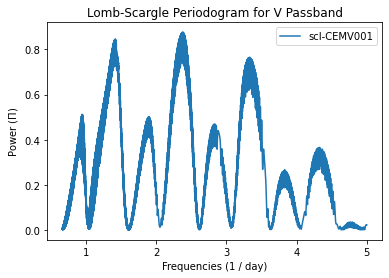

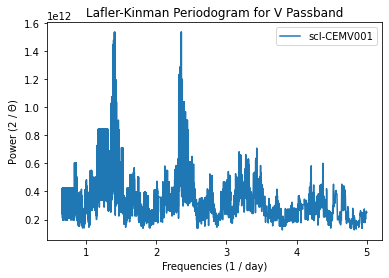

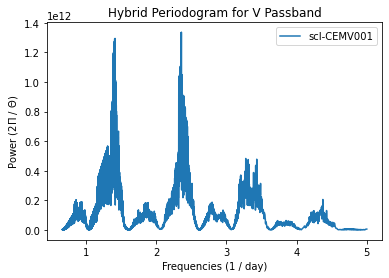

In [31]:
best_period_V001_V = plot_periodogram(sculptor_photometry, 'V', star = 'scl-CEMV001')[4];
print(f"\nBest Period in V Passband is {best_period_V001_V} Days")

Finding optimal frequency:
 - Estimated peak width = 2.75
 - Using 5 steps per peak; omega_step = 0.55
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 51 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00343
 - Using 5 steps per peak; omega_step = 0.000685
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 39742 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00343
 - Using 5 steps per peak; omega_step = 0.000686
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 39699 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps



Best Period is 0.711081108110811 Days


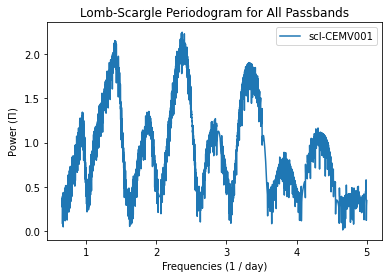

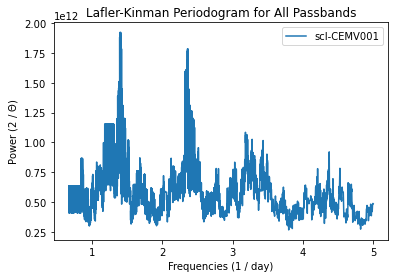

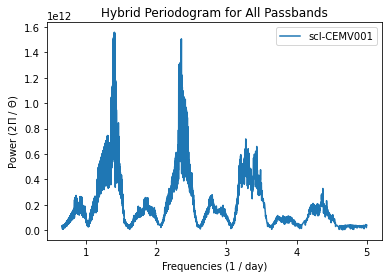

In [32]:
best_period_V001 = find_best_period(sculptor_photometry, star = 'scl-CEMV001')[2];
print(f"\nBest Period is {best_period_V001} Days")

In [112]:
sculptor_best_periods = np.array(pickle.load(open("sculptor_periods_unweighted.pkl", "rb")))[:, 2:].T[0]
sculptor_periods['Best Period (Days)'] = sculptor_best_periods
sculptor_periods.head()

,Star,Period (Days),Best Period (Days)
0,scl-CEMV001,0.420876,0.426787
1,scl-CEMV002,0.305970,0.306393
2,scl-CEMV005,0.309746,0.309058
3,scl-CEMV006,0.332111,0.484248
4,scl-CEMV008,0.281318,0.565655


In [113]:
np.average(np.abs(sculptor_periods.iloc[:, 2] - sculptor_periods.iloc[:, 1]))

0.04624601405601034

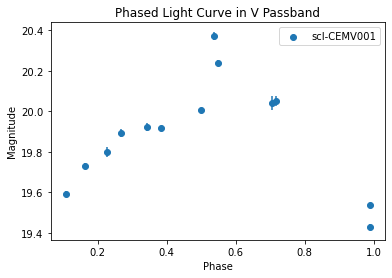

In [35]:
V001_phases = phase_light_curve(sculptor_periods.iloc[0, 2], sculptor_photometry, 'V', star = 'scl-CEMV001')

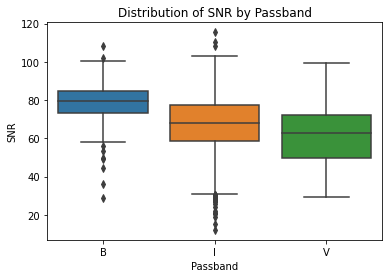

In [99]:
binned_data = sculptor_photometry.copy()
binned_data['SNR'] = 1 / (10**(binned_data['Uncertainty in Magnitude'] / 2.5) - 1)

bin_pass = binned_data[['Star', 'Passband', 'SNR']].groupby(['Star', 'Passband']).mean().reset_index()
sns.boxplot(data = bin_pass, x = 'Passband', y = 'SNR')
plt.title('Distribution of SNR by Passband');

,Star,SNR,Difference
0,scl-CEMV001,63.244520,0.002453
1,scl-CEMV002,86.582400,0.000968
2,scl-CEMV005,89.196736,0.000922
3,scl-CEMV006,79.890738,0.001556
4,scl-CEMV008,80.483498,0.280189


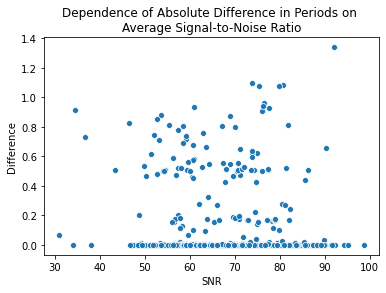

In [98]:
sculptor_weighted_periods = np.array(pickle.load(open("sculptor_periods_grid.pkl", "rb")))[:, 2:].T[0]

binned_data = binned_data[['Star', 'SNR']]
binned_data = binned_data.groupby('Star').mean().reset_index()
binned_data['Difference'] = np.abs(sculptor_periods['Period (Days)'] - sculptor_weighted_periods)
display(binned_data.head())

sns.scatterplot(data = binned_data, x = 'SNR', y = 'Difference')
plt.title('Dependence of Absolute Difference in Periods on \nAverage Signal-to-Noise Ratio');

In [38]:
sorted_diff = binned_data.sort_values(by = 'Difference', ascending = False)
print(len(binned_data[binned_data['Difference'] < 0.01]))
display(sorted_diff.merge(sculptor_pulsation[['Star', 'Uncertainty Flag on Period']], on = 'Star').head(5))

407


,Star,SNR,Difference,Uncertainty Flag on Period
0,scl-CEMV610,91.939951,1.340596,::
1,scl-CEMV258,73.885090,1.099950,:
2,scl-CEMV066,80.754553,1.084707,:
3,scl-CEMV393,79.899304,1.078712,NaN
4,scl-CEMV570,75.458405,1.075999,NaN


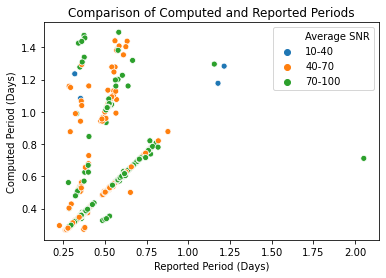

In [39]:
weighted_comp = sculptor_periods.copy()
weighted_comp['Computed Period (Days)'] = sculptor_weighted_periods
weighted_comp.drop(['Best Period (Days)'], axis = 1, inplace = True)
weighted_comp = weighted_comp.rename({'Period (Days)' : 'Reported Period (Days)'}, axis = 1)
weighted_comp['SNR'] = binned_data['SNR']

cut_bins = [10, 40, 70, 100]
cut_labels = ['10-40', '40-70', '70-100']
weighted_comp['Average SNR'] = pd.cut(weighted_comp['SNR'], bins = cut_bins, labels = cut_labels)

sns.scatterplot(data = weighted_comp, x = 'Reported Period (Days)', y = 'Computed Period (Days)', 
                hue = 'Average SNR', hue_order = cut_labels)
plt.title('Comparison of Computed and Reported Periods')
plt.xlabel('Reported Period (Days)')
plt.ylabel('Computed Period (Days)');

In [40]:
saha_test = sculptor_photometry[sculptor_photometry["Star"] == "scl-CEMV006"].replace({"B" : 0, "V" : 1, "I" : 2})
psearch_py(saha_test["HJD-2400000.0"].values, saha_test["Magnitude"].values, saha_test["Uncertainty in Magnitude"].values, 
           saha_test["Passband"].values.astype(np.float64), ["B", "V", "I"], 0.2, 0.02)

psearch: BEGIN =====================================================

REFERENCE:
 
Saha, A., & Vivas, A. K. 2017, Astronomical Journal, 154, 231;
    "A Hybrid Algorithm for Period Analysis from Multiband Data with
    Sparse and Irregular Sampling for Arbitrary Light-curve Shapes"
IDL CODE (Abhijit Saha):
    https://github.com/AbhijitSaha/Psearch
PYTHON/CYTHON/C CODE (Kenenth Mighell):
    https://github.com/AbhijitSaha/Psearch/tree/master/psearch_py

MODULE:
    C:\Pranav\UCB_Sophomore_Year\Weisz Group Research\Variable-Stars\psearch_py.py
    [psearch_py (0.23.6)  mode: pure Python  (*** slow ***) ]
 
psearch:  B  filter
periodpsi2: BEGIN
periodpsi2: minimum and maximum periods:     0.20000041  1320.94270000 days
periodpsi2: number of period (frequency) samples:  660371   <----------
periodpsi2:  28  observations  <----------
scargle: DONE    15.180 seconds
ctheta_slave: DONE     1.263 seconds
periodpsi2_py:  1  of  1   (thresh loop)
scargle: DONE    14.112 seconds
ctheta_slave: DO

(array([1.32094270e+03, 1.30786406e+03, 1.29504186e+03, ...,
        2.00001014e-01, 2.00000712e-01, 2.00000409e-01]),
 array([[0.00521007, 0.00716458, 0.00884693, ..., 0.04936826, 0.04082595,
         0.03461308],
        [0.02439224, 0.01748266, 0.01471674, ..., 0.00171398, 0.00077742,
         0.00056475],
        [0.03780797, 0.03782823, 0.03772467, ..., 0.00633489, 0.00617518,
         0.00519455]]),
 array([[0.18209996, 0.18170473, 0.17997847, ..., 0.80742687, 0.7496327 ,
         0.73941871],
        [0.09111107, 0.08882884, 0.08435297, ..., 0.18685083, 0.14254542,
         0.13654014],
        [0.05731224, 0.05705217, 0.05655512, ..., 0.02040544, 0.01804984,
         0.01507047]]))

# Investigating the Effects of Sparsity and Noise

In [41]:
def simulate_sparsity_and_noise(dataset, passband, sparsity = 1.0, signal_to_noise = 0, **kwargs):
    """Simulates sparsity and noise in the light curve data of a specific star in a specific passband."""
    
    times, magnitudes, errors = filter_data(dataset, passband, **kwargs)
    simulated = pd.DataFrame({"HJD-2400000.0" : times, "Magnitude" : magnitudes, 
                              "Uncertainty in Magnitude" : errors, "Passband" : passband})
    
    if sparsity != 1.0:
        simulated = simulated.sample(frac = sparsity)
    
    if signal_to_noise != 0:
        simulated["Uncertainty in Magnitude"] = 2.5 * np.log10(1 + 1 / signal_to_noise)
        noise = [np.random.normal(0, error) for error in simulated["Uncertainty in Magnitude"].values]
        simulated["Magnitude"] = simulated["Magnitude"] + noise
    
    return simulated


def simulate_best_period(dataset, sparsity = 1.0, signal_to_noise = 0, version = "gatspy", weighted = True, 
                         plot = False, name = "Unknown", lc = False, **kwargs):
    """Simulates sparsity and noise in the light curve data of a specific star.
    Then, determines the effect on the calculation of the best period."""
    
    passbands = dataset["Passband"].unique()
    initial = simulate_sparsity_and_noise(dataset, passbands[0], sparsity, signal_to_noise, **kwargs)
    
    for passband in passbands[1:]:
        
        new_data = simulate_sparsity_and_noise(dataset, passband, sparsity, signal_to_noise, **kwargs)
        initial = pd.concat([initial, new_data], axis = 0)
    
    best_periods = find_best_period(initial, version = version, weighted = weighted, plot = plot, name = name, **kwargs)
    
    if lc:
        phases = phase_light_curve(best_periods[2], initial, passbands[1], name = name, **kwargs)
        
    return best_periods

In [42]:
sparse_results_lomb = pickle.load(open("sparse_periods.pkl", "rb"))[:, :, 0:1].T[0]
sparse_results_lomb = np.array([np.average(lst) for lst in sparse_results_lomb])
sparse_results_lomb

array([0.45638304, 0.50163016, 0.50163016, 0.50163016, 0.51744754,
       0.46137814, 0.50153655, 0.50163796, 0.58770657, 0.50163796,
       0.37420962, 0.4580134 , 1.06153895, 0.52712571, 0.45468247,
       0.6749739 ])

In [43]:
sparse_results_lk = pickle.load(open("sparse_periods.pkl", "rb"))[:, :, 1:2].T[0]
sparse_results_lk = np.array([np.average(lst) for lst in sparse_results_lk])
sparse_results_lk

array([0.82929933, 0.50144294, 0.50163016, 0.50163016, 0.86212241,
       0.62219122, 0.50153655, 0.50162236, 0.54751955, 0.58239944,
       0.50134153, 0.46127673, 0.70587019, 0.75713951, 0.75432863,
       0.5829845 ])

In [44]:
sparse_results_hybrid = pickle.load(open("sparse_periods.pkl", "rb"))[:, :, 2:].T[0]
sparse_results_hybrid = np.array([np.average(lst) for lst in sparse_results_hybrid])
sparse_results_hybrid

array([0.46062666, 0.50144294, 0.50163016, 0.50163016, 0.85905151,
       0.50152875, 0.50163016, 0.50163016, 0.68682848, 0.46127673,
       0.50152875, 0.50152875, 0.61849365, 0.48488449, 0.45789899,
       0.42170337])

In [45]:
best_periods = list(zip(sparse_results_lomb, sparse_results_lk, sparse_results_hybrid))
best_periods

[(0.4563830383038303, 0.8292993299329933, 0.4606266626662665),
 (0.5016301630163015, 0.5014429442944295, 0.5014429442944295),
 (0.5016301630163015, 0.5016301630163015, 0.5016301630163015),
 (0.5016301630163015, 0.5016301630163015, 0.5016301630163015),
 (0.5174475447544755, 0.8621224122412241, 0.8590515051505153),
 (0.46137813781378123, 0.622191219121912, 0.5015287528752874),
 (0.5015365536553654, 0.5015365536553653, 0.5016301630163015),
 (0.5016379637963795, 0.5016223622362234, 0.5016301630163015),
 (0.5877065706570658, 0.5475195519551955, 0.6868284828482847),
 (0.5016379637963797, 0.5823994399439942, 0.46127672767276723),
 (0.3742096209620961, 0.5013415341534153, 0.5015287528752874),
 (0.45801340134013413, 0.46127672767276723, 0.5015287528752874),
 (1.0615389538953894, 0.7058701870187016, 0.6184936493649364),
 (0.5271257125712572, 0.7571395139513949, 0.48488448844884485),
 (0.4546824682468245, 0.7543286328632862, 0.45789898989898975),
 (0.6749738973897389, 0.5829844984498449, 0.421703

In [46]:
sparsities = np.array([1.0, 0.5, 0.25, 0.125])
sn_ratios = np.array([1, 10, 100, 1000])
combinations = itertools.product(sparsities, sn_ratios)

parameters = pd.DataFrame(list(combinations), columns = ["Sparsity", "Signal-to-Noise"])
results = pd.DataFrame(best_periods, columns = ["Lomb-Scargle", "Lafler-Kinman", "Hybrid Method"])
results_table = pd.concat([parameters, results], axis = 1)
results_table

,Sparsity,Signal-to-Noise,Lomb-Scargle,Lafler-Kinman,Hybrid Method
0,1.000,1,0.456383,0.829299,0.460627
1,1.000,10,0.501630,0.501443,0.501443
2,1.000,100,0.501630,0.501630,0.501630
3,1.000,1000,0.501630,0.501630,0.501630
4,0.500,1,0.517448,0.862122,0.859052
5,0.500,10,0.461378,0.622191,0.501529
6,0.500,100,0.501537,0.501537,0.501630
7,0.500,1000,0.501638,0.501622,0.501630
8,0.250,1,0.587707,0.547520,0.686828
9,0.250,10,0.501638,0.582399,0.461277


In [47]:
results_table.pivot(index = "Sparsity", columns = "Signal-to-Noise")

Lomb-Scargle                               Lafler-Kinman  \
Signal-to-Noise         1         10        100       1000          1      
Sparsity                                                                   
0.125               1.061539  0.527126  0.454682  0.674974      0.705870   
0.250               0.587707  0.501638  0.374210  0.458013      0.547520   
0.500               0.517448  0.461378  0.501537  0.501638      0.862122   
1.000               0.456383  0.501630  0.501630  0.501630      0.829299   

                                              Hybrid Method            \
Signal-to-Noise      10        100       1000          1         10     
Sparsity                                                                
0.125            0.757140  0.754329  0.582984      0.618494  0.484884   
0.250            0.582399  0.501342  0.461277      0.686828  0.461277   
0.500            0.622191  0.501537  0.501622      0.859052  0.501529   
1.000            0.501443  0.501630  0.501630      0.460627  0.501443   

                                     
Signal-to-Noise      100       1000  
Sparsity                             
0.125            0.457899  0.421703  
0.250            0.501529  0.501529  
0.500            0.501630  0.501630  
1.000            0.501630  0.501630

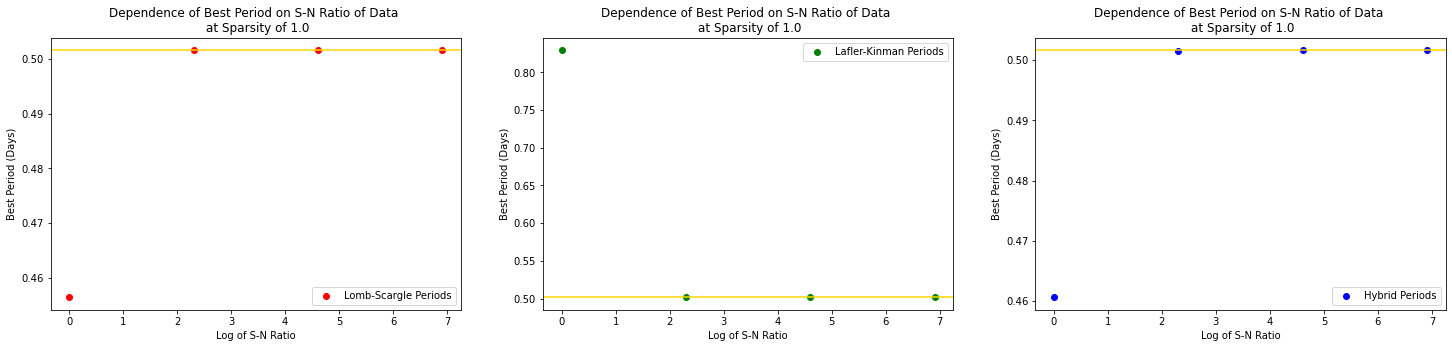

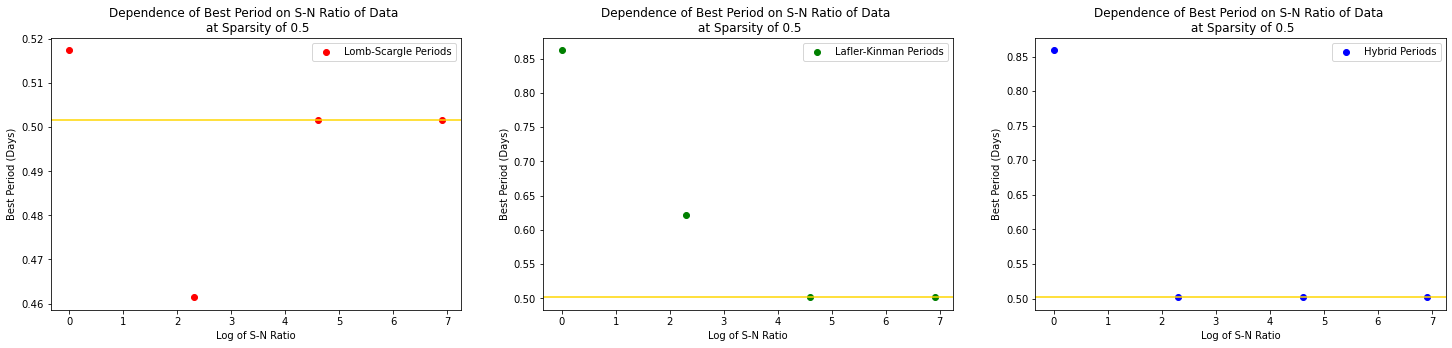

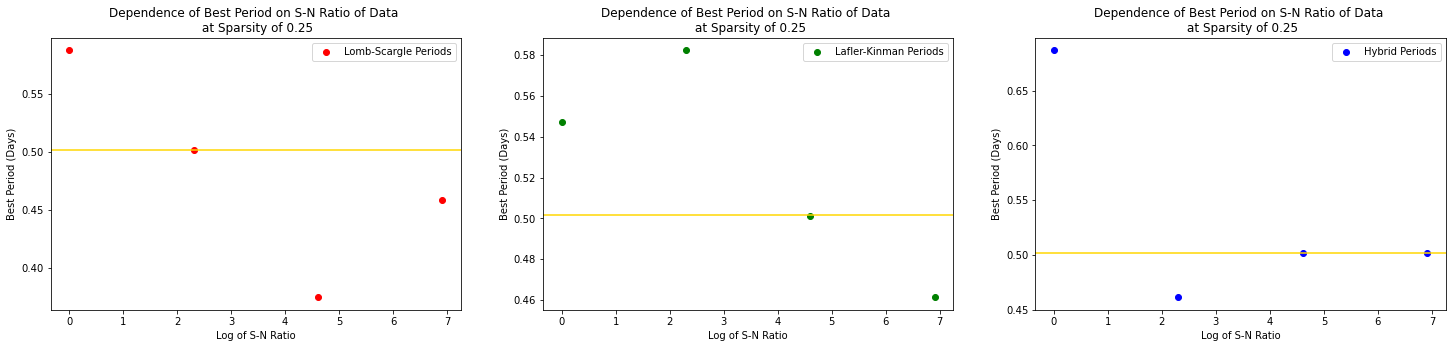

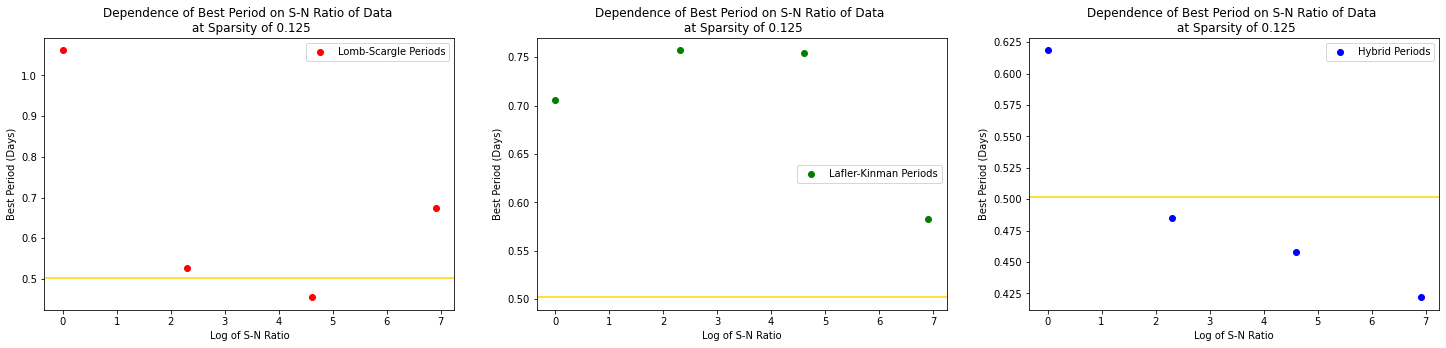

In [48]:
for sparsity in sparsities:
    filtered_results = results_table[results_table["Sparsity"] == sparsity]
    fig, axs = plt.subplots(1, 3, figsize = (25, 5))
    for ax in axs:
        ax.set_title(f'Dependence of Best Period on S-N Ratio of Data \n at Sparsity of {sparsity}')
        ax.set_xlabel('Log of S-N Ratio')
        ax.set_ylabel('Best Period (Days)')
    axs[0].scatter(np.log(sn_ratios), filtered_results["Lomb-Scargle"], label = 'Lomb-Scargle Periods', color = 'r')
    axs[1].scatter(np.log(sn_ratios), filtered_results["Lafler-Kinman"], label = 'Lafler-Kinman Periods', color = 'g')
    axs[2].scatter(np.log(sn_ratios), filtered_results["Hybrid Method"], label = 'Hybrid Periods', color = 'b')
    for ax in axs:
        ax.axhline(y = 0.501624, color = 'gold', linestyle = '-')
        ax.legend();

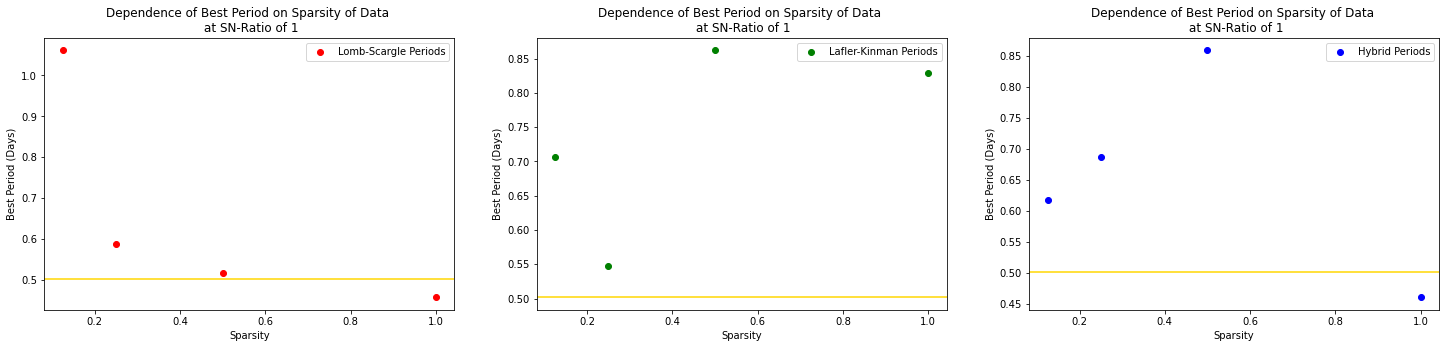

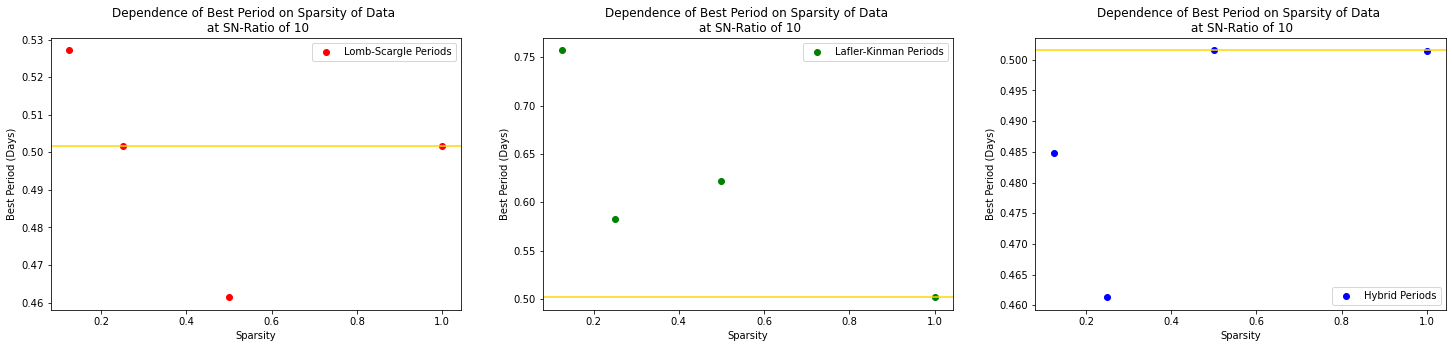

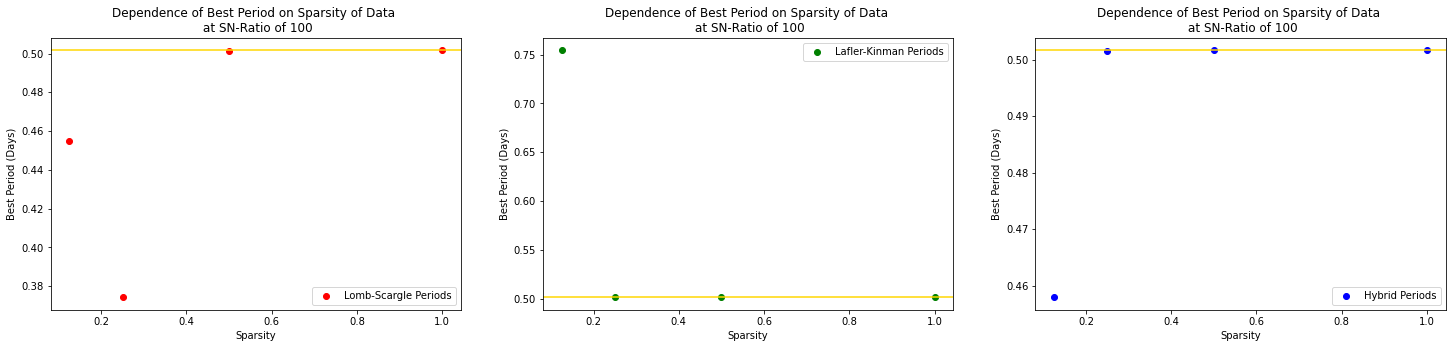

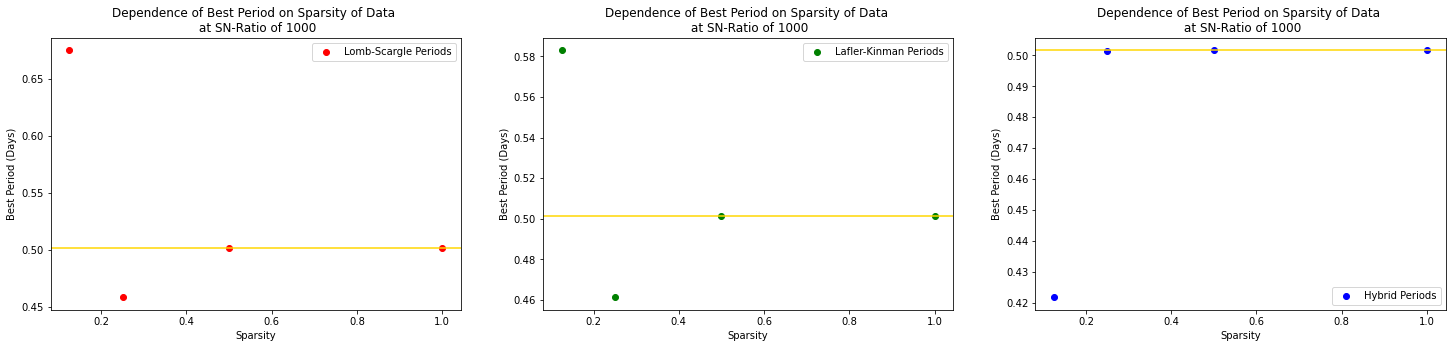

In [49]:
for sn in sn_ratios:
    filtered_results = results_table[results_table["Signal-to-Noise"] == sn]
    fig, axs = plt.subplots(1, 3, figsize = (25, 5))
    for ax in axs:
        ax.set_title(f'Dependence of Best Period on Sparsity of Data \n at SN-Ratio of {sn}')
        ax.set_xlabel('Sparsity')
        ax.set_ylabel('Best Period (Days)')
    axs[0].scatter(sparsities, filtered_results["Lomb-Scargle"], label = 'Lomb-Scargle Periods', color = 'r')
    axs[1].scatter(sparsities, filtered_results["Lafler-Kinman"], label = 'Lafler-Kinman Periods', color = 'g')
    axs[2].scatter(sparsities, filtered_results["Hybrid Method"], label = 'Hybrid Periods', color = 'b')
    for ax in axs:
        ax.axhline(y = 0.501624, color = 'gold', linestyle = '-')
        ax.legend();

Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15021 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00907
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15019 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15022 steps
Zooming-in on 5 candidate peaks:
 -

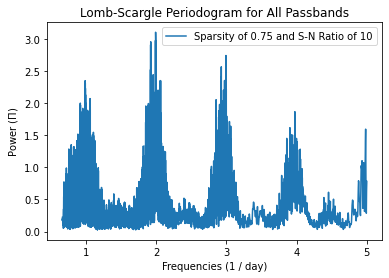

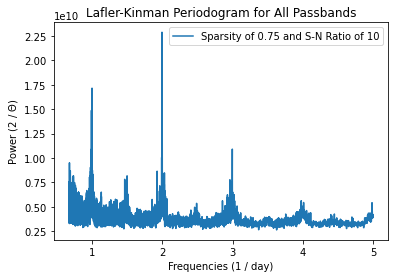

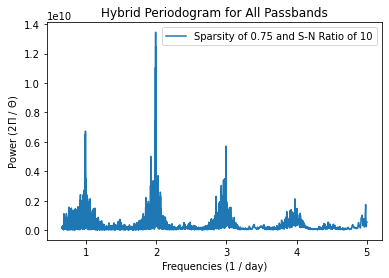

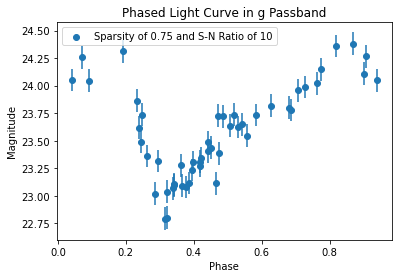

In [50]:
dense_noisy = simulate_best_period(saha, sparsity = 0.75, signal_to_noise = 10, plot = True, 
                                   name = "Sparsity of 0.75 and S-N Ratio of 10", lc = True)

Finding optimal frequency:
 - Estimated peak width = 0.00943
 - Using 5 steps per peak; omega_step = 0.00189
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14432 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Finding optimal frequency:
 - Estimated peak width = 0.00946
 - Using 5 steps per peak; omega_step = 0.00189
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14391 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00906
 - Using 5 steps per peak; omega_step = 0.00181
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 15020 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Finding optimal frequency:
 - Estimated peak width = 0.00945
 - Using 5 steps per peak; omega_step = 0.00189
 - User-specified period range:  0.2 to 1.5
 - Computing periods at 14412 steps
Zooming-in on 5 candidate peaks:
 - 

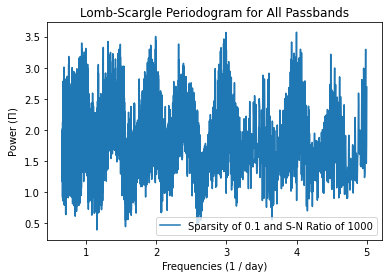

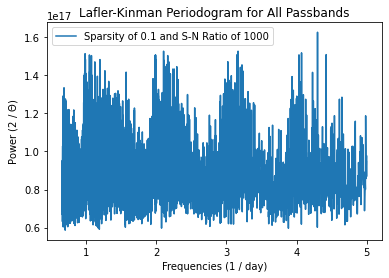

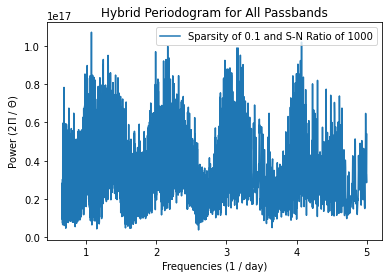

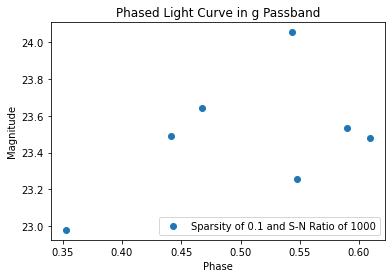

In [51]:
sparse_signal = simulate_best_period(saha, sparsity = 0.1, signal_to_noise = 1000, plot = True, 
                                     name = "Sparsity of 0.1 and S-N Ratio of 1000", lc = True)